In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from scipy.stats import ttest_1samp, pearsonr
from scipy.io import loadmat
from sklearn.metrics import r2_score
import seaborn as sns
import h5py

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'Functional_Fusion')
sys.path.append(dname)
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

In [8]:
dname = join(dir_git,'fracridge')
sys.path.append(dname)
from fracridge import fracridge

In [9]:
dname = join(dir_git,'GLMsingle')
sys.path.append(dname)
import glmsingle
from glmsingle.glmsingle import getcanonicalhrflibrary
from glmsingle.utils.squish import squish

In [10]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [11]:
subj = 'S01'

### Load the mask

In [12]:
mask = simage.load_mask(subj=subj)
mask.shape

(116, 116, 57)

### Load Y_raw

In [13]:
run = 1
y_raw = simage.load_yraw(subj=subj, run=run)
y_raw.shape

(116, 116, 57, 410)

In [14]:
y_raw = simage.trim_ydata(ydata=y_raw, glm=1)
y_raw.shape

(116, 116, 57, 407)

In [18]:
y_raw = simage.masking_data(data=y_raw, mask=mask)
y_raw.shape

(116, 116, 57, 407)

In [16]:
# plotting.view_img(stat_map_img=image.index_img(y_raw, index=10))

### Make the data into 2-D

In [67]:
tmp = mask.get_fdata()
V = tmp > 0
V.shape

(116, 116, 57)

In [68]:
yraw_flatten = y_raw.get_fdata()[V,:]
yraw_flatten.shape

(214338, 407)

#### Plot

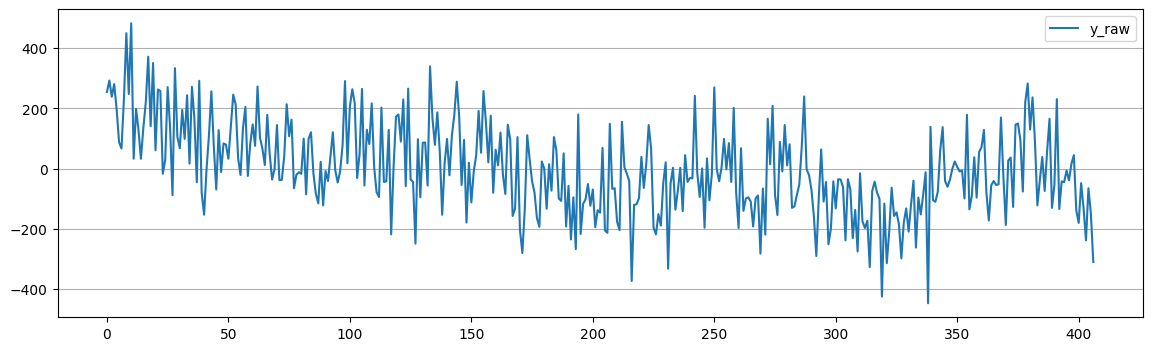

In [69]:
x = np.arange(yraw_flatten.shape[-1])
idx = 10
# idx = np.unravel_index(np.nanargmax(R2[:].flatten()),np.shape(R2))
y = yraw_flatten[idx,:]

fig, ax = plt.subplots(figsize=(14,4))
ax.plot(x,y-y.mean(), label='y_raw')
ax.grid(axis='y')
ax.legend()

---

In [13]:
glm = 1
dir_glm = ssingle.get_dir_glmsingle(glm)
dir_glm

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_1'

### Load designSINGLE matrix

In [14]:
tr, stimdur, _ = ssingle.get_TR_stimdur_stimorder(subj=subj, glm=glm)
print(tr, stimdur)

1.0 2.0


In [15]:
run = 1
rr = 0

(407, 544)


<Axes: >

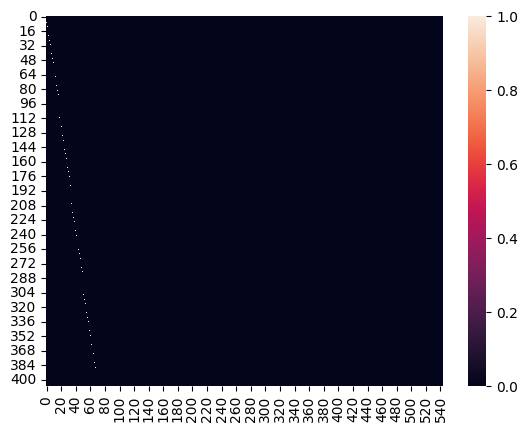

In [16]:
design = ssingle.get_designSINGLE(subj=subj, glm=glm, run=run)
print(design.shape)
sns.heatmap(design)

---

### Load the model

In [17]:
model = ssingle.load_model(subj, glm, type='D')
model.keys()

<KeysViewHDF5 ['#refs#', 'FRACvalue', 'HRFindex', 'HRFindexrun', 'R2', 'R2run', 'glmbadness', 'meanvol', 'modelmd', 'noisepool', 'pcnum', 'pcregressors', 'pcvoxels', 'rrbadness', 'scaleoffset', 'xvaltrend']>

#### Find HRF estimated by GLMsingle

(52, 20)


<Axes: >

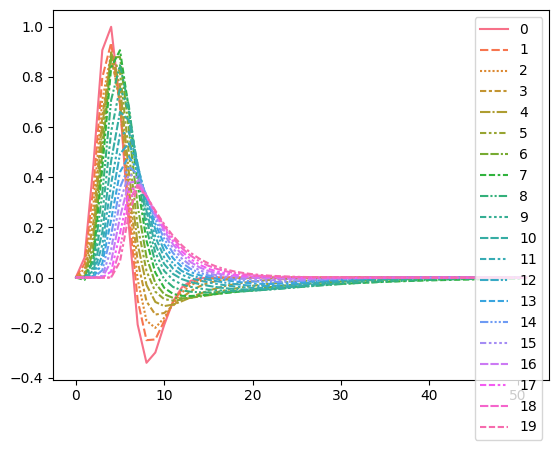

In [18]:
hrflib = getcanonicalhrflibrary(stimdur,tr).T
print(hrflib.shape)
sns.lineplot(hrflib)

### HRF index Map

/home/sungbeenpark/anaconda3/envs/sss/lib/python3.8/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



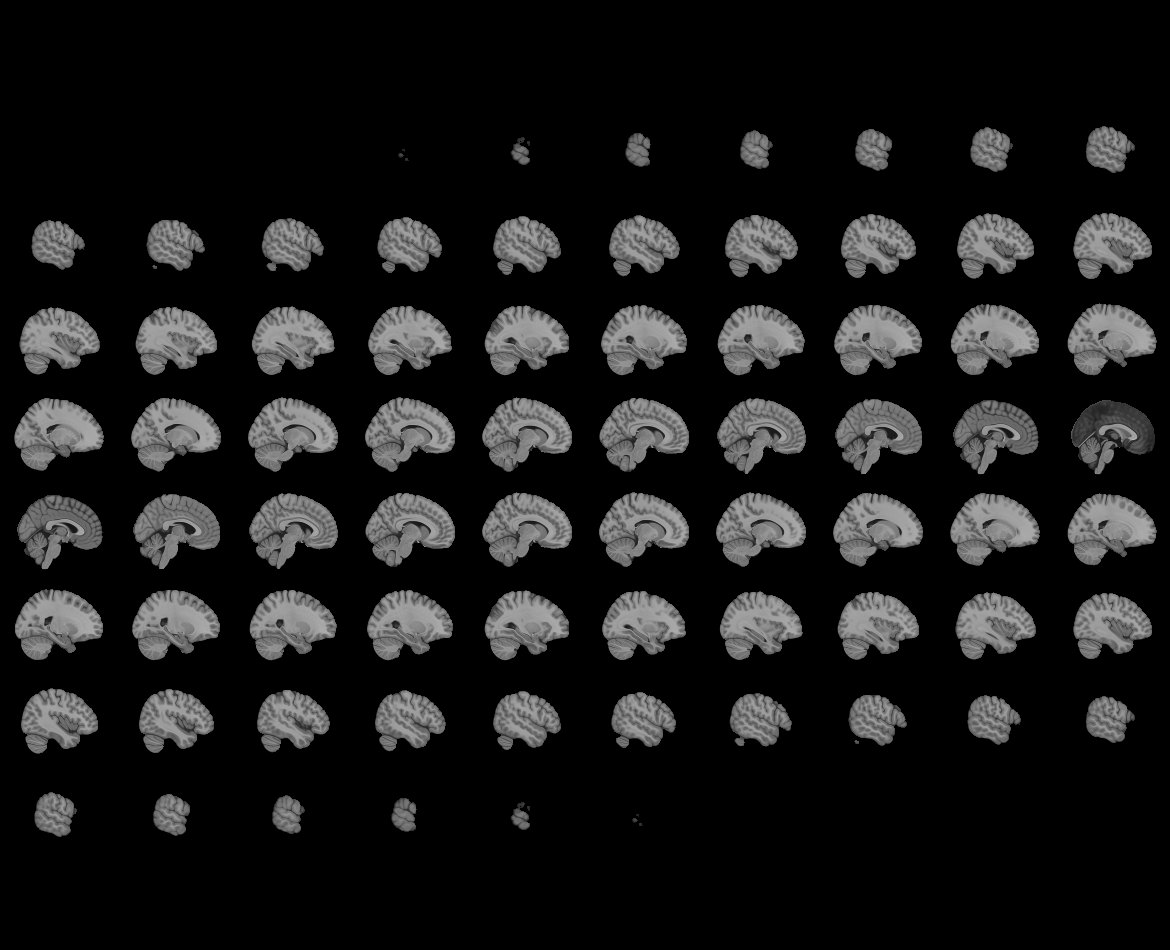
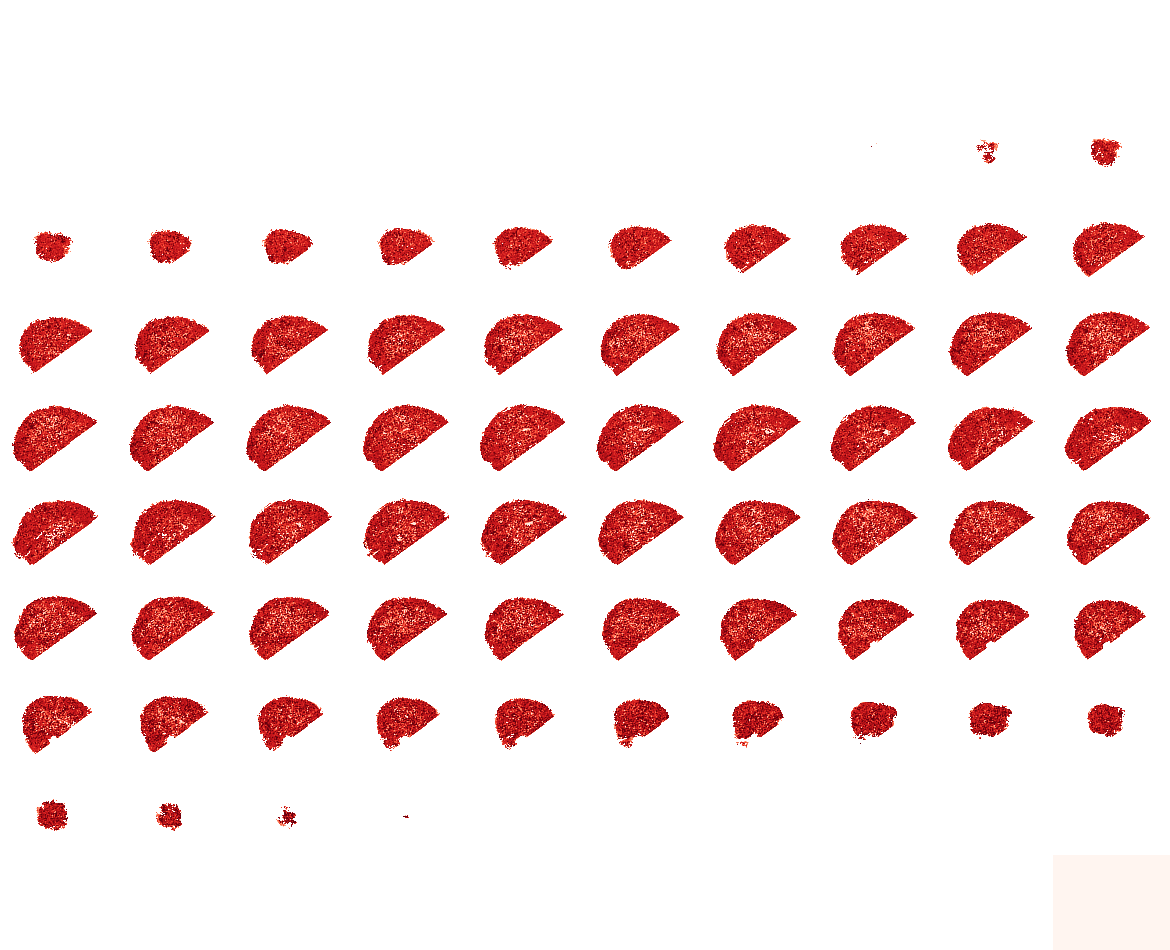

In [19]:
hrfnii = ssingle.get_index_map(subj, glm, type='D')
plotting.view_img(hrfnii, vmin=0, vmax=20, symmetric_cmap=False, cmap=cm.Reds)

---

### Design Matrix

In [34]:
## Get the GLMdenoise Principal Components for a run
ref = model['pcregressors'][:][rr,0]
noise_pcs = model[ref][:]
noise_pcs.shape

(10, 407)

In [35]:
## The number of PCs used in the final model is stored in 'pcnum'
num_pcs_to_use = model['pcnum'][:].flatten()
print(num_pcs_to_use)
num_pcs_to_use = int(num_pcs_to_use[0])

[7.]


In [50]:
## Keep only the PCs that were actually used in the model
if num_pcs_to_use > 0:
    selected_pcs = noise_pcs[:num_pcs_to_use,:].T;
else:
    selected_pcs = []; # No PCs were selected
selected_pcs.shape

(407, 7)

In [37]:
## Generate the Polynomial Regressors
num_timepoints = design.shape[0]
run_duration_min = (num_timepoints * tr) / 60;
poly_degree = round(run_duration_min * 0.5);
print(poly_degree)

3


In [40]:
## Create the polynomial regressors (including the constant term)
polynomial_regressors = np.zeros((num_timepoints, poly_degree+1));
polynomial_regressors.shape

(407, 4)

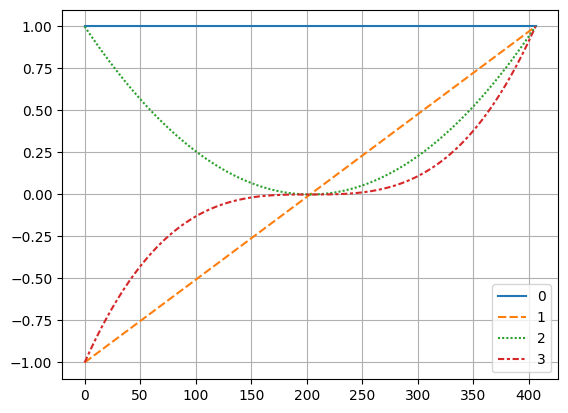

In [48]:
polynomial_regressors[:,0] = 1.
for p in np.arange(poly_degree):
    polynomial_regressors[:,p+1] = np.linspace(-1, 1, num_timepoints) ** (p+1)
g = sns.lineplot(polynomial_regressors)
g.legend()
g.grid()

In [51]:
## Combine into a single nuisance regressor matrix
## Also add any 'extraregressors' you might have used
extra_regs = [] # Populate this if you used opt.extraregressors

<Axes: >

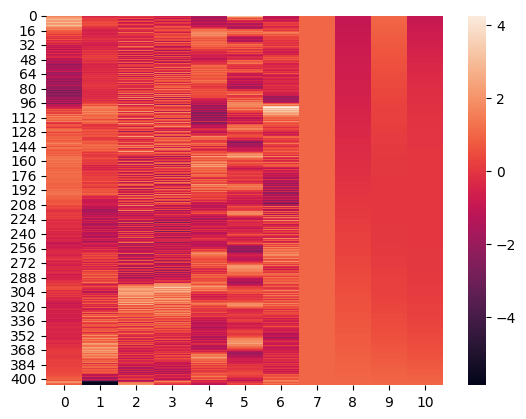

In [60]:
Xs = np.hstack([selected_pcs, polynomial_regressors])
sns.heatmap(Xs)

---

In [70]:
yraw_flatten.shape

(214338, 407)

In [71]:
Xs.shape

(407, 11)

In [73]:
betas_nuisance = np.linalg.pinv(Xs)@yraw_flatten.T
betas_nuisance.shape

(11, 214338)

In [74]:
yres_flatten = (Xs @ betas_nuisance).T
yres_flatten.shape

(214338, 407)

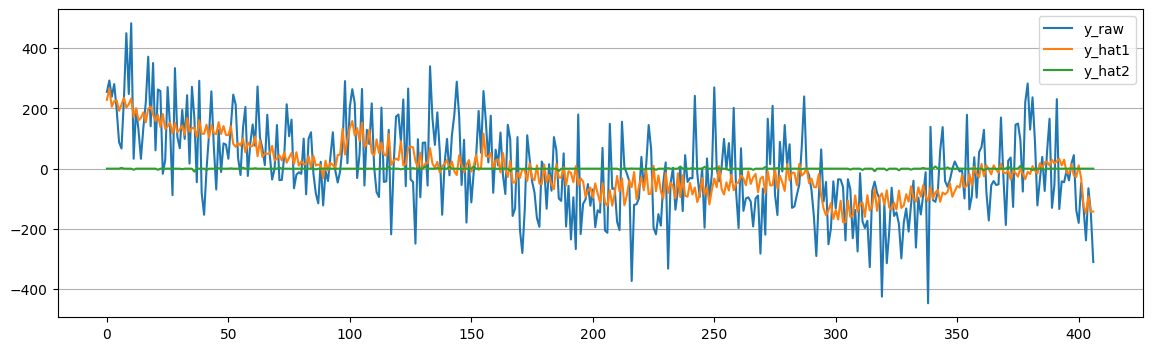

In [82]:
x = np.arange(yraw_flatten.shape[-1])
idx = 10
# idx = np.unravel_index(np.nanargmax(R2[:].flatten()),np.shape(R2))

fig, ax = plt.subplots(figsize=(14,4))
y = yraw_flatten[idx,:]
ax.plot(x,y-y.mean(), label='y_raw')

yres_flatten = (Xs @ betas_nuisance).T
y = yres_flatten[idx,:]
ax.plot(x,y-y.mean(), label='y_hat1')

yres_flatten = (design @ betas_flatten.T).T
y = yres_flatten[idx,:]
ax.plot(x,y-y.mean(), label='y_hat2')

ax.grid(axis='y')
ax.legend()

---
---

### R2 Map

/home/sungbeenpark/anaconda3/envs/sss/lib/python3.8/site-packages/nilearn/plotting/html_stat_map.py:198: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  data = safe_get_data(stat_map_img, ensure_finite=True)
/home/sungbeenpark/anaconda3/envs/sss/lib/python3.8/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



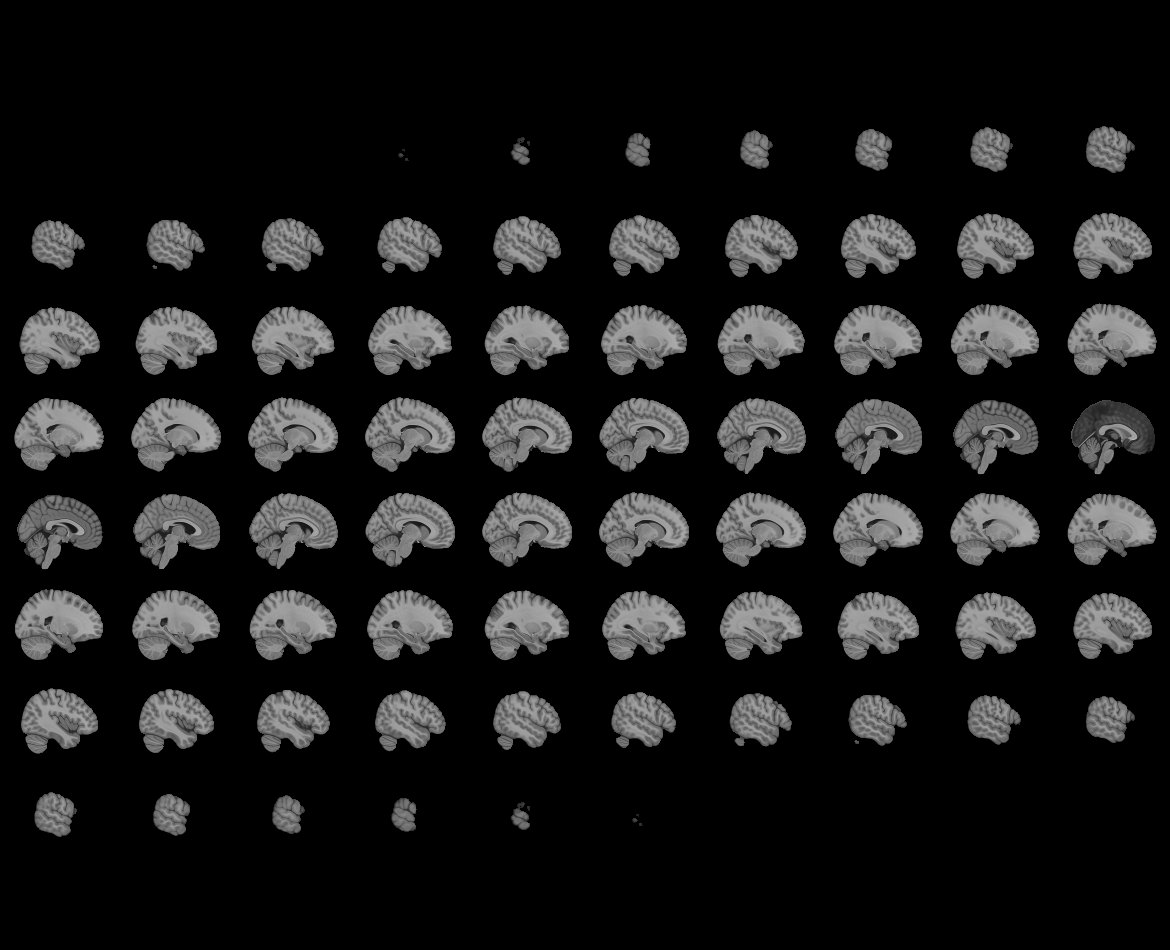
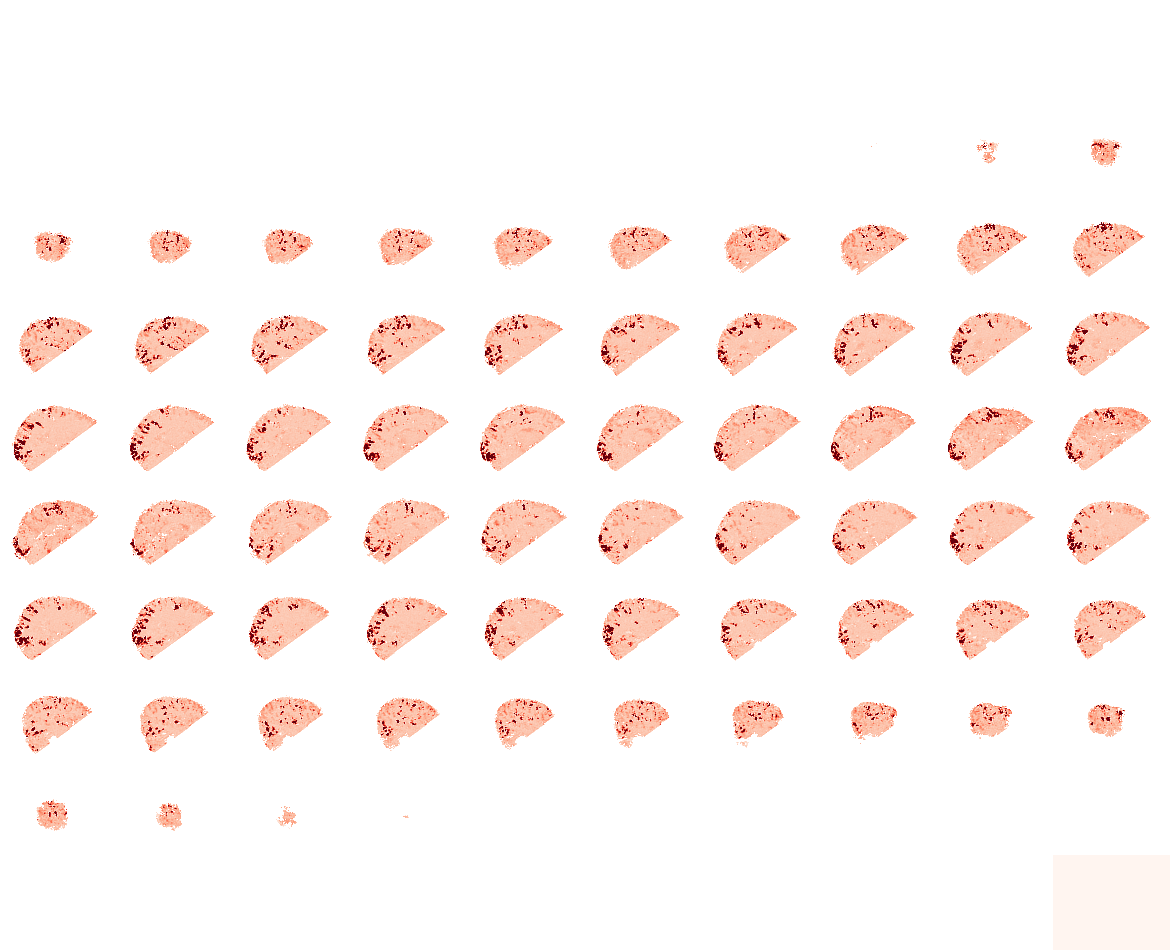

In [21]:
r2nii = ssingle.get_R2_map(subj, glm, type='D')
plotting.view_img(r2nii, vmin=0, vmax=10, symmetric_cmap=False, cmap=cm.Reds)

In [78]:
R2_flatten = R2[V]
R2_flatten.shape

(214338,)

### $\beta$

In [20]:
betas = ssingle.get_beta_map(subj=subj, glm=glm, type='D')
betas.shape

(116, 116, 57, 544)

/home/sungbeenpark/anaconda3/envs/sss/lib/python3.8/site-packages/nilearn/plotting/html_stat_map.py:198: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  data = safe_get_data(stat_map_img, ensure_finite=True)
/home/sungbeenpark/anaconda3/envs/sss/lib/python3.8/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



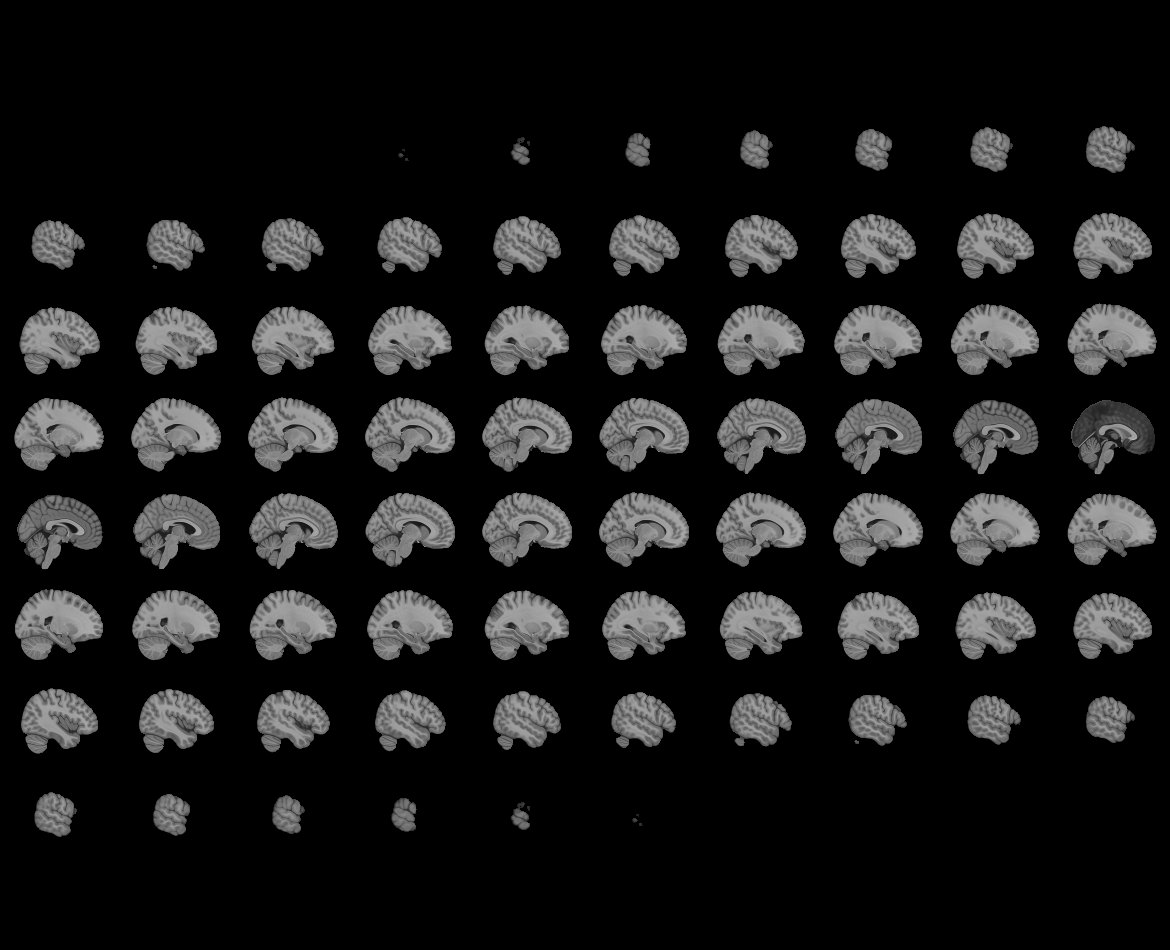
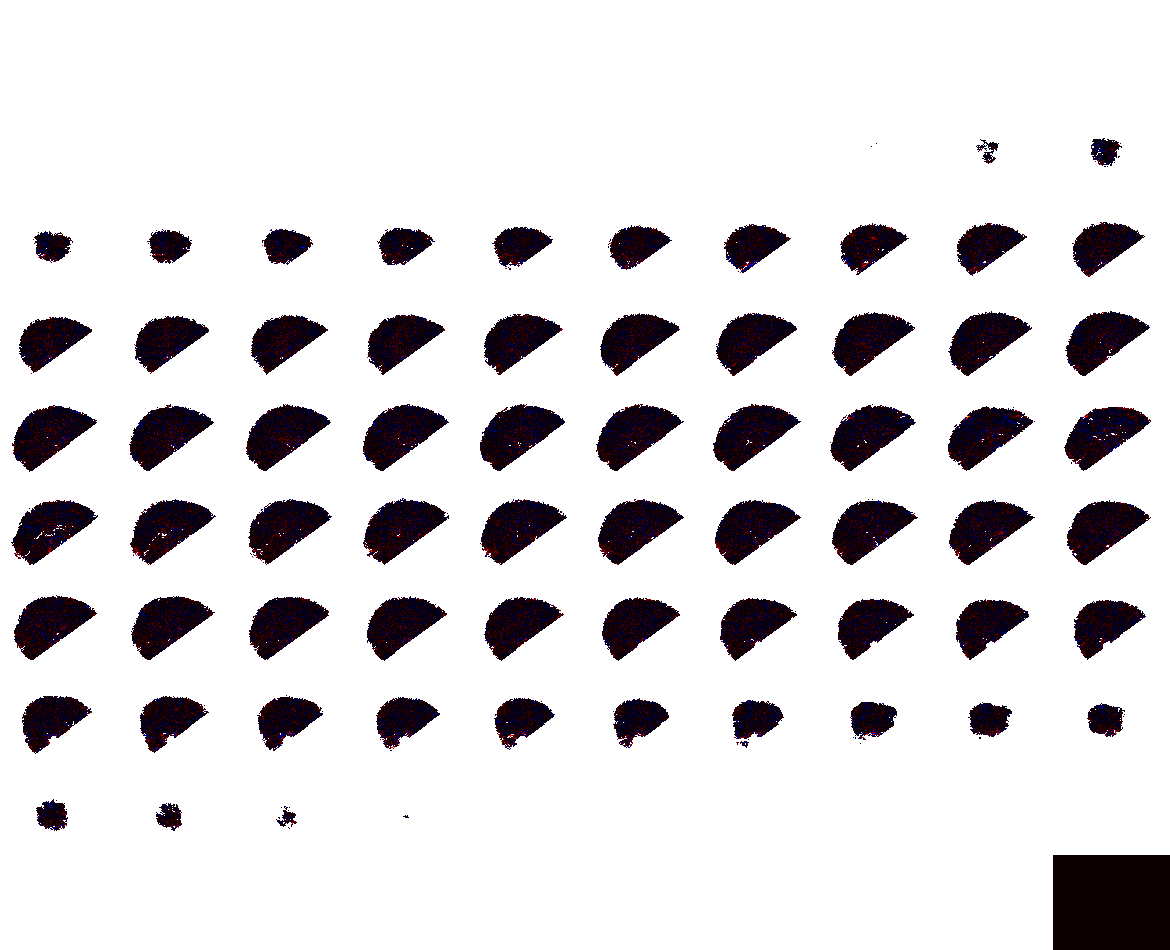

In [21]:
plotting.view_img(stat_map_img=image.index_img(betas, index=10))

In [ ]:
betas_flatten = betas[V,:]
print(betas_flatten.shape)

In [79]:
# hrfii = squish(GLMsingle['HRFindex'],3)[np.nanargmax(R2.flatten())].astype(int) - 1
# print(hrfii)
# meansignal = squish(GLMsingle['meanvol'],3)[np.nanargmax(R2.flatten())]
meansignal = GLMsingle['meanvol'][:]
print(meansignal.shape)
meansignal = meansignal.transpose(2,1,0)
print(meansignal.shape)
meansignal_flatted = meansignal[V]
print(meansignal_flatted.shape)

(57, 116, 116)
(116, 116, 57)
(214338,)


/opt/anaconda3/envs/SSS/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



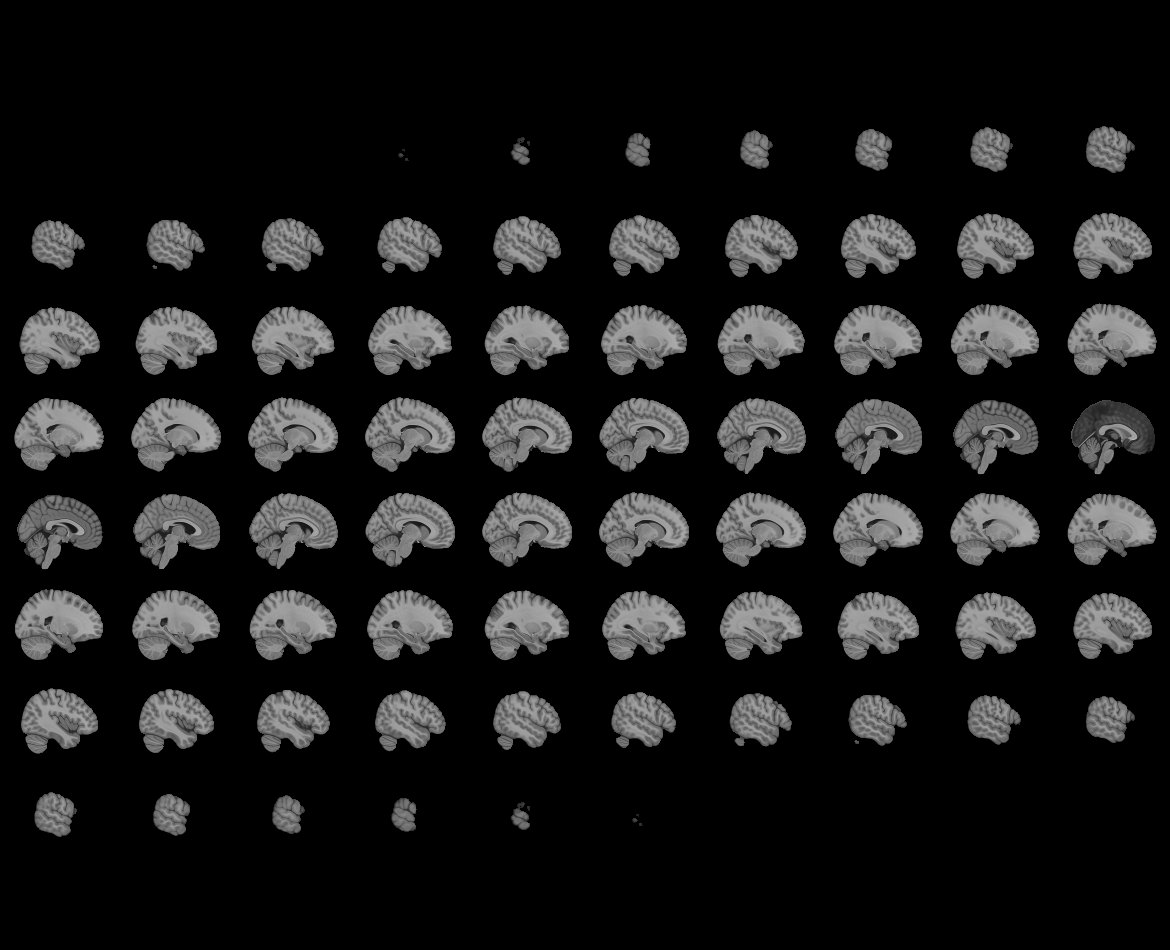
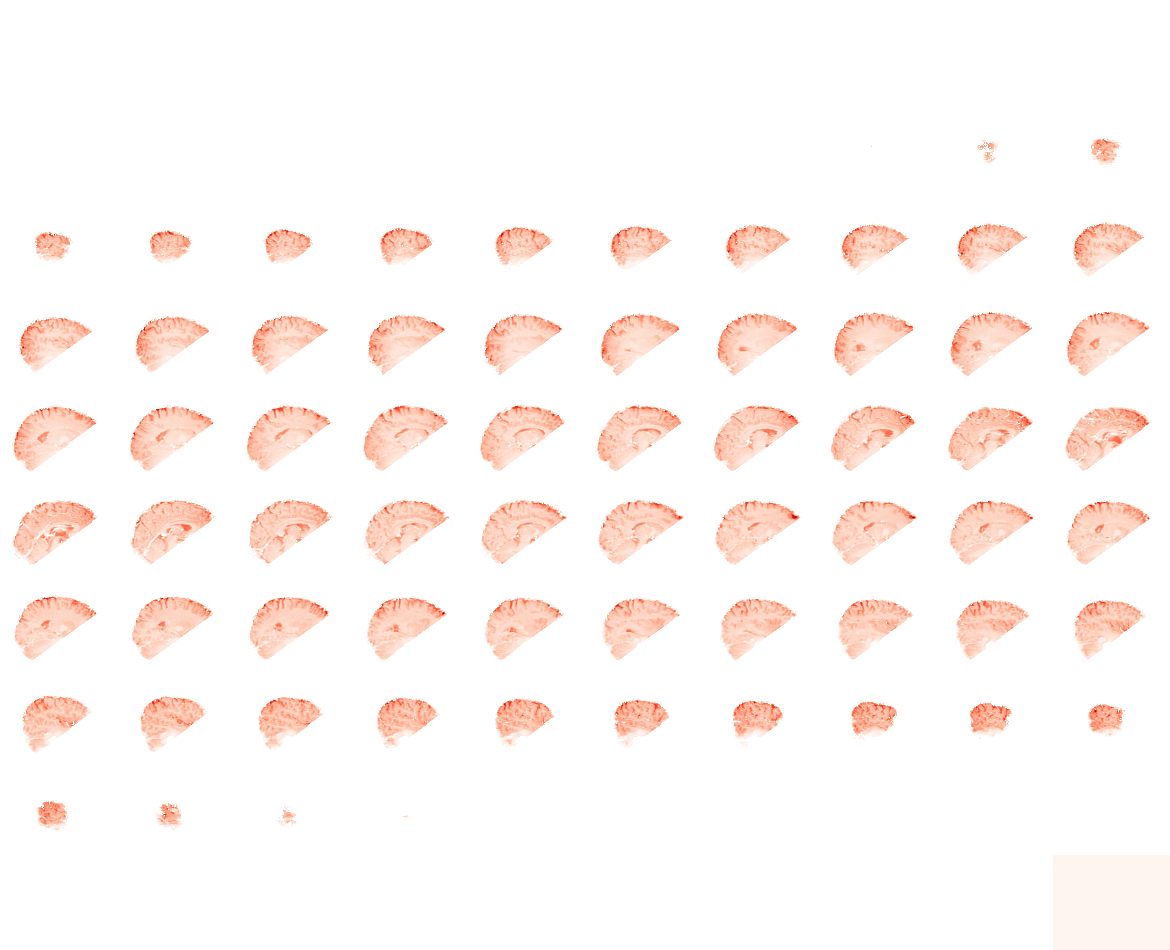

In [80]:
meansignal = nb.Nifti1Image(meansignal, affine=mask.affine, header=mask.header)
meansignal = simage.masking_data(data=meansignal, mask=mask)
plotting.view_img(meansignal, symmetric_cmap=False, cmap=cm.Reds)

---

In [83]:
# convert each run design matrix from sparse array to full numpy array, append
mydesign = Xs.T
mydata = yraw_flatten.T
mybeta = betas_flatten.T

$$
Y_{raw} = X_{conv}\beta+\epsilon
$$

In [111]:
print(mydata.shape)
print(mydesign.shape)
print(hrfii_flatten.shape)
print(mybeta.shape)
print(meansignal_flatted.shape)

(407, 214338)
(407, 544)
(214338,)
(544, 214338)
(214338,)


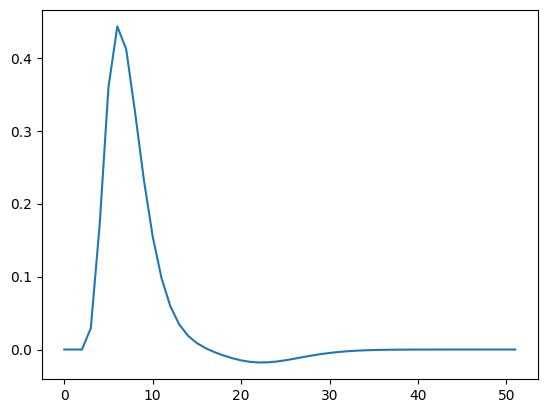

In [112]:
idx_voxel = 200
idx_hrf = int(hrfii_flatten[idx_voxel])-1
myhrf = hrflib[:,idx_hrf]
plt.plot(myhrf)

(407, 544)


<Axes: >

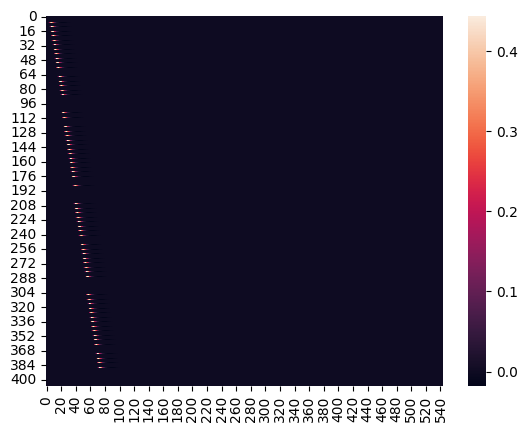

In [113]:
myhrf = myhrf[np.newaxis,:]
# convolve HRF into design matrix
design0 = scipy.signal.convolve2d(mydesign,myhrf)
design0 = design0[:,:mydesign.shape[1]]
print(design0.shape)
sns.heatmap(design0)

1762.626
(544,)


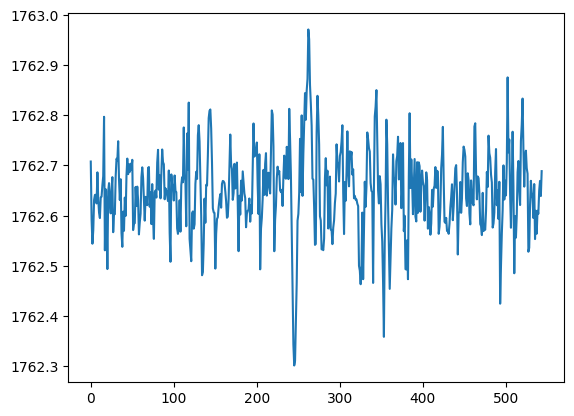

In [108]:
betatmp = mybeta[...,idx_voxel]*0.01 + meansignal_flatted[idx_voxel]
print(meansignal_flatted[idx_voxel])
print(betatmp.shape)
plt.plot(betatmp)

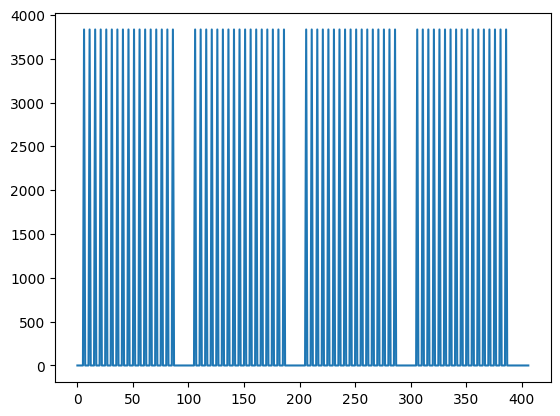

In [114]:
predicted = design0 @ betatmp
plt.plot(predicted)

In [ ]:
#zeromean predicted tcs
predicted = predicted - np.mean(predicted)

In [ ]:
ax.plot(x, predicted, label='predicted')
ax.legend()

---

In [ ]:
list_sn = su.get_list_sn()

In [ ]:
glm = 1
for nn in tqdm(list_sn):
    subj = 'S'+nn
    ssingle.calc_y_hat(subj=subj, glm=glm)

---

In [ ]:
list_run = su.get_list_run()

---

In [ ]:
Xs = ssingle.get_designSINGLE(subj,glm,run=1)
Xs.shape

In [ ]:
subj = 'S01'
run = 'r01'

dir_work = join(dir_glm, subj)
fname = join(dir_work,'%s.Yhat.%s.nii'%(subj,run))
fname = join(dir_work,'tmap_(1,S).nii')
img = nb.load(fname)

In [ ]:
plotting.view_img(
    # stat_map_img=image.index_img(img, index=10)
    stat_map_img=img
)

---

In [ ]:
run = 1

In [ ]:
y_raw, affine, header = ssingle.get_y_raw(subj=subj, glm=glm, run=run)

## check the validation
assert y_raw.shape[-1] == T, f'T mismatch: X has {T} rows, y has {y_raw.shape[-1]} timepoints'

## Flattened in 2D for vectorized operations
Y_2d = y_raw.reshape(*spatial_shape, T).reshape(V, T).T  # (T, V)
del y_raw

In [ ]:
## get y_res
R = Y_2d - Y_hat  # (T, V)

In [ ]:
voxel = 400000
plt.plot(np.arange(T),Y_2d[:,voxel])
plt.plot(np.arange(T),Y_hat[:,voxel])
# plt.plot(np.arange(T),R[:,voxel])